In [1]:
from sklearn.model_selection import train_test_split
from sklearn import datasets, svm
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.metrics import confusion_matrix
from sklearn.cluster import AgglomerativeClustering
import numpy as np
from math import sqrt
from shapleycomposition import ShapleyExplainer
from composition_stats import ilr, sbp_basis
from bifurc_tree import create_tree_from_sbp, init_graph, build_graph, sbp_from_aggloclustchildren
import plotly.graph_objects as go
from mahalanobis_matrix import mahalanobis_matrix
import matplotlib.pyplot as plt

In [2]:
import os

out_dir = os.path.join('figures', 'moreclasses')
os.makedirs(out_dir, exist_ok=True)

In [3]:
K = 10         #Index of the instance you want to test in the test set
N_class = 10   #Number of class, the dimension of the simplex is therefore N_class-1
N_feat  = 6    #In this example, since the number of feature of the digit dataset is quite large (64), we propose to reduce it with a PCA

#load the dataset, take a subset of N_class classes, scale it and split into a training and testing set
X, Y = datasets.load_digits(return_X_y=True)
subset_i = np.where(Y < N_class)
X = X[subset_i]
Y = Y[subset_i]
X = scale(X)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

#Reduce the number of feature to N_feat with a PCA
pca = PCA(n_components=N_feat)
X_train = pca.fit_transform(X_train)
X_test  = pca.transform(X_test)


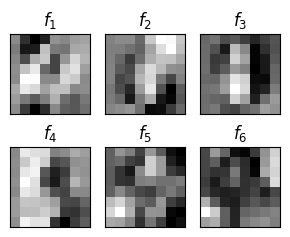

In [4]:
fig, ax_list = plt.subplots(nrows=2, ncols=int(N_feat/2), figsize=(3, 2.5))
for i, (c, ax) in enumerate(zip(pca.components_, ax_list.flatten())):
    ax.set_title(f'$f_{i+1}$')
    ax.imshow(c.reshape([8,8]), cmap='grey')
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
fig.tight_layout()
fig.savefig(os.path.join(out_dir, 'ex_gt4_pca_components.pdf'))

In [5]:
#train an SVM classifier
svc_linear = svm.SVC(kernel='rbf', probability=True)
svc_linear.fit(X_train, Y_train)

SVC(probability=True)

In [6]:
#Choose a sequential binary partition matrix and plot the corresponding bifurcation tree
# sbpmatrix = np.array([[1,1,-1,-1,1,1,1],[1,-1,0,0,-1,-1,-1],[0,1,0,0,-1,-1,-1],[0,0,0,0,1,-1,-1],[0,0,0,0,0,1,-1],[0,0,1,-1,0,0,0]])
#sbpmatrix = np.array([[1,-1,1,-1,1,-1,1],[1,0,1,0,-1,0,-1],[0,0,0,0,1,0,-1],[1,0,-1,0,1,0,0],[0,1,0,1,0,-1,0],[0,1,0,-1,0,0,0]])

#Get a sequential binary parition from the agglomeration of classes from a distance matrix between classes. Distance matrix is here made of the mahalanobis distance between a pair of classes in the ILR space output by the classifier (assuming normal distribution with same covariance matrix between a pair of classes).
M = mahalanobis_matrix(svc_linear.predict_proba, X_test, Y_test)
sbpmatrix = sbp_from_aggloclustchildren(AgglomerativeClustering(metric='precomputed', linkage='average').fit(M).children_)

#basis = np.flip(sbp_basis(sbpmatrix), axis=0)
basis = sbp_basis(sbpmatrix)
root = create_tree_from_sbp(sbpmatrix, N_class)

##Visualise the tree using graphviz
graph = init_graph()
build_graph(root, graph)
#graph.render('tree.pdf', view=True)
graph       #plot the bifurcation tree


ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH

In [13]:
# Explain all the predictions in the test set
explainer = ShapleyExplainer(svc_linear.predict_proba, X_train, N_class, sbpmatrix=sbpmatrix,
                            names_classes=[str(i) for i in range(N_class)])
(shapley, base) = explainer.explain_instance(np.array(X_test[K]))


print("True label of the tested instance: ", end="")
print(Y_test[K])

#get the model prediction for the Kth instance of the test partition
pred = svc_linear.predict_proba(X_test[K].reshape(1,-1))
print("Prediction on the simplex: ",end="")
print(pred)
ilr_pred = ilr(pred, basis=basis)
print("Prediction in the ILR space: ",end="")
print(ilr_pred)

#The sum of the base distribution and the shapley composition in the ILR space is equal to the predicted probability distribution
sum_shap_base = np.array(shapley).sum(axis=0)+base
print("Sum of the shapley composition and the base distribution in the ILR space: ", end="")
print(sum_shap_base)

(6,)
True label of the tested instance: 2
Prediction on the simplex: [[0.00168813 0.00286664 0.96795076 0.00606728 0.00780499 0.00258988
  0.00155261 0.00280244 0.00237145 0.00430582]]
Prediction in the ILR space: [ 0.11807771  0.24249638  0.05917245  4.28149772  0.08666795 -2.10248585
 -2.34371296  0.04630831  1.93489055]
Sum of the shapley composition and the base distribution in the ILR space: [ 0.11807774  0.24249639  0.05917245  4.28149771  0.08666801 -2.10248586
 -2.34371291  0.04630833  1.93489058]


In [8]:
#SUMMARIZE WITH NORM, COSINE AND INNER PRODUCTS

(norm_shapley, proj_shap_class, cos_shap_shap) = explainer.summarize()

List of the features sorted by their Shapley strength (norm of their Shapley composition):
	 feature n.1: 3.8955814
	 feature n.3: 2.1892871
	 feature n.4: 1.3077529
	 feature n.2: 1.1110937
	 feature n.6: 1.0424524
	 feature n.5: 0.5499829

Projection of the Shapley compositions on the class vectors:
		feature n.1	feature n.2	feature n.3	feature n.4	feature n.5	feature n.6	
0:        	1.6011288	-0.4508564	0.3361064	0.2113030	-0.0353295	-0.1751525	
1:        	-0.8350976	0.2944390	0.4295501	-0.0077702	-0.0012017	0.2995954	
2:        	-0.1596750	0.1289260	0.2281555	0.6528748	-0.1952911	-0.2019502	
3:        	-0.5145137	0.0516103	1.1418528	0.1777804	-0.3036647	0.1650606	
4:        	-1.8471267	-0.6054562	-1.3654969	-0.5020704	-0.0400105	-0.1118488	
5:        	-0.3876169	-0.3136712	-0.5187623	0.4554900	0.1330720	-0.3873887	
6:        	1.7322351	-0.0108982	0.9075213	-0.9092972	0.3964775	-0.4425634	
7:        	1.8769274	0.3014250	-0.7906812	-0.1719302	-0.1176792	0.7367957	
8:        	0.303673

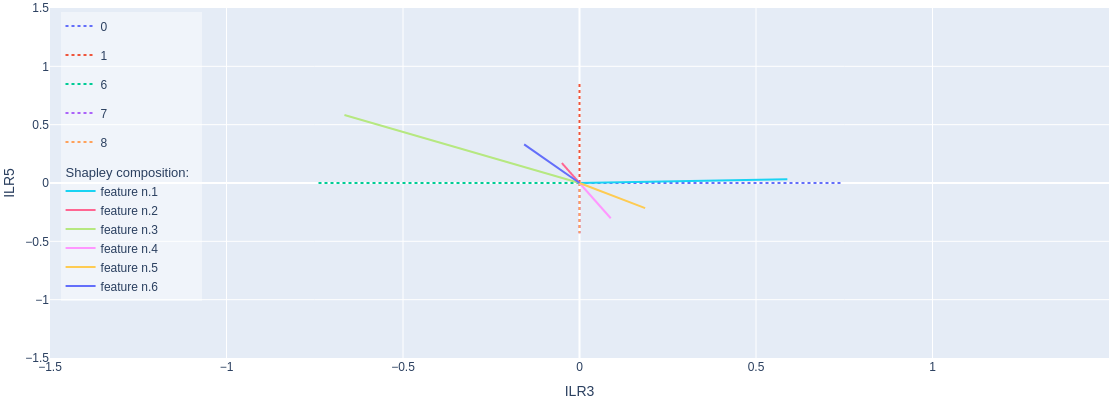

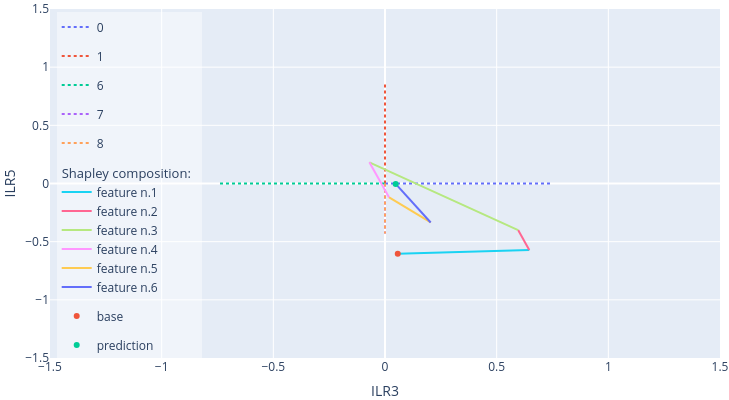

In [12]:
#PLOT the a ILR subspace (corresponding to the chosen ILR components listed in balances).
#plot range [-lim, lim]
#If shapley_sum is True, the sum of the shapley vectors are summed from the base distribution to the prediction

fig = explainer.plot_ilr_space(balances=[3, 5], lim=1.5, figsize=400)
fig.write_image(os.path.join(out_dir, 'ex_gt4_ilrplot.pdf'))

fig = explainer.plot_ilr_space(balances=[3, 5], shapley_sum=True, lim=1.5, figsize=400)
fig.write_image(os.path.join(out_dir, 'ex_gt4_ilrplotsum.pdf'))

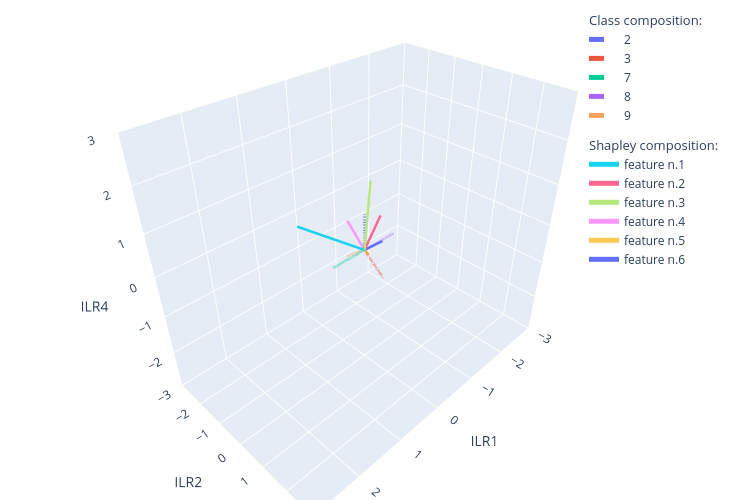

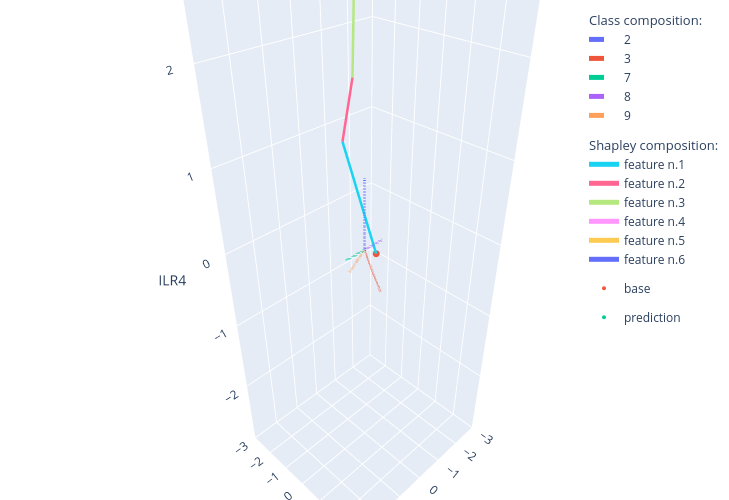

In [10]:
#PLOT the a ILR subspace (corresponding to the chosen ILR components listed in balances).
#plot range [-lim, lim]
#If shapley_sum is True, the sum of the shapley vectors are summed from the base distribution to the prediction

fig = explainer.plot_ilr_space(balances=[1, 2, 4], lim=3)
fig = explainer.plot_ilr_space(balances=[1, 2, 4], shapley_sum=True, lim=3)


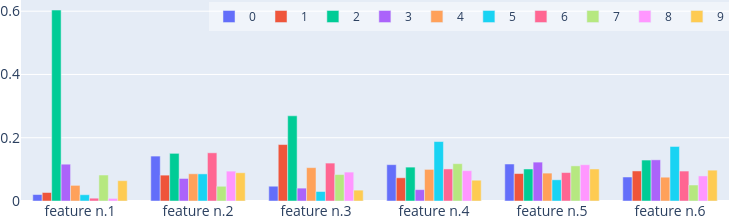

In [11]:
#Plot the Shapley compositions as histograms

fig = explainer.shapley_histogram(figheight=220, figwidth=550)
fig.write_image(os.path.join(out_dir, 'ex_gt4_histo.pdf'))